In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import openpyxl
from scipy.stats import spearmanr, pearsonr

In [29]:
# Load file & sheet

fs = pd.read_excel(
    r'C:\Users\vnsp8460\Desktop\Johnny_folder\fs_actual_uplift\[CFS] Automation + Optimization.xlsx',
    sheet_name='raw_uplift_eval'
    )

In [30]:
# Create new price bins

fs['promo_price_bin'] = pd.cut(
    fs['promo_price'], 
    bins=[0, 25000, 50000, 75000, 100000, 150000, 200000, 500000, np.inf], 
    labels=[
        '0-25k',
        '25k-50k',
        '50k-75k', 
        '75k-100k', 
        '100k-150k',
        '150k-200k',
        '200k-500k', 
        '500k+'
        ])

# Get Category Data

temp = pd.read_parquet(r'C:\Users\vnsp8460\Desktop\Johnny_folder\flash_sale\fs_uplift_0527_fts.parquet')
temp = temp[['model_id', 'item_id', 'item_name', 'level1_global_be_category']]
temp = temp.drop_duplicates(subset=['model_id', 'item_id', 'item_name'])

fs = fs.merge(temp, on=['model_id', 'item_id', 'item_name'], how='inner')

In [31]:
# Actual uplift vs Predicted uplift

fs_grouped = fs.groupby(['skulc', 'promo_price_bin'],observed=True).agg({
    'uplift_base_l7d': ['mean', 'std'],
    'uplift_base_l14d': ['mean', 'std'],
    'uplift_base_l30d': ['mean', 'std', 'count'],
    'uplift_score': ['mean', 'std'], 
}).reset_index()

fs_grouped.columns = [
    'skulc', 'promo_price_bin', 'actual_uplift_mean_l7d', 'actual_uplift_std_l7d',
    'actual_uplift_mean_l14d', 'actual_uplift_std_l14d', 
    'actual_uplift_mean_l30d', 'actual_uplift_std_l30d', 'count',
    'pred_uplift_score_mean', 'pred_uplift_score_std'
    ]

fs_grouped_sorted = fs_grouped.sort_values(by='pred_uplift_score_mean',ascending=False)

fs_grouped_sorted = fs_grouped_sorted[[
    'skulc',
    'promo_price_bin',
    'pred_uplift_score_mean',
    'actual_uplift_mean_l7d',
    'actual_uplift_mean_l14d',
    'actual_uplift_mean_l30d',
    'count'
    ]]

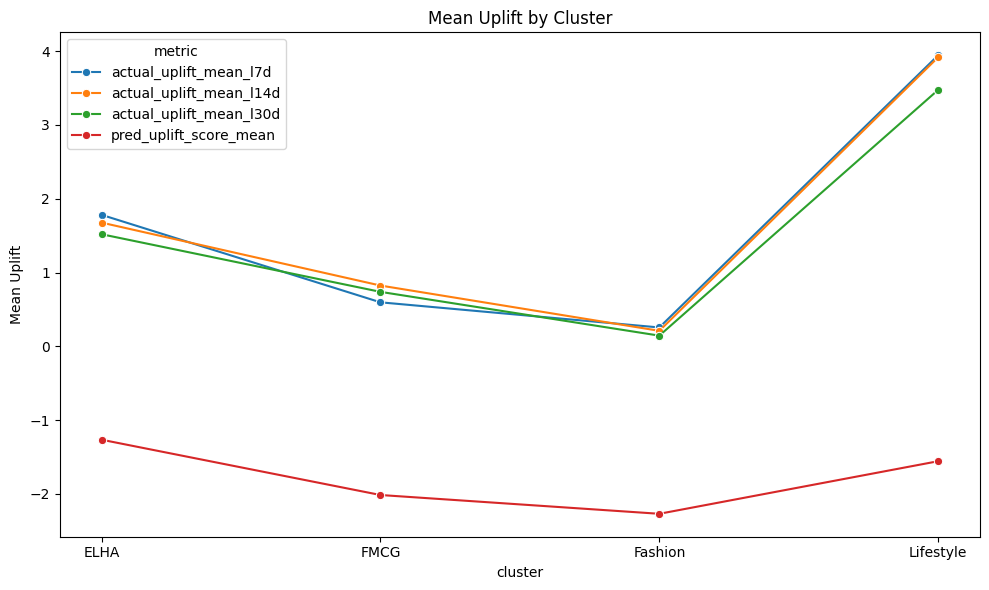

In [32]:
fs_grouped = fs.groupby(['cluster'],observed=True).agg({
    'uplift_base_l7d': ['mean', 'std'],
    'uplift_base_l14d': ['mean', 'std'],
    'uplift_base_l30d': ['mean', 'std'],
    'uplift_score': ['mean', 'std'], 
}).reset_index()

fs_grouped.columns = [
    'cluster', 'actual_uplift_mean_l7d', 'actual_uplift_std_l7d',
    'actual_uplift_mean_l14d', 'actual_uplift_std_l14d', 
    'actual_uplift_mean_l30d', 'actual_uplift_std_l30d', 
    'pred_uplift_score_mean', 'pred_uplift_score_std'
    ]

melted = pd.melt(
    fs_grouped,
    id_vars='cluster',
    value_vars=[
        'actual_uplift_mean_l7d',
        'actual_uplift_mean_l14d',
        'actual_uplift_mean_l30d',
        'pred_uplift_score_mean'
    ],
    var_name='metric',
    value_name='uplift'
)

plt.figure(figsize=(10, 6))
sns.lineplot(data=melted, x='cluster', y='uplift', hue='metric', marker='o')
plt.title("Mean Uplift by Cluster")
plt.ylabel("Mean Uplift")
plt.tight_layout()
plt.show()

In [33]:
fs['uplift_base_avg']=(fs['uplift_base_l7d']+fs['uplift_base_l14d']+fs['uplift_base_l30d'])/3

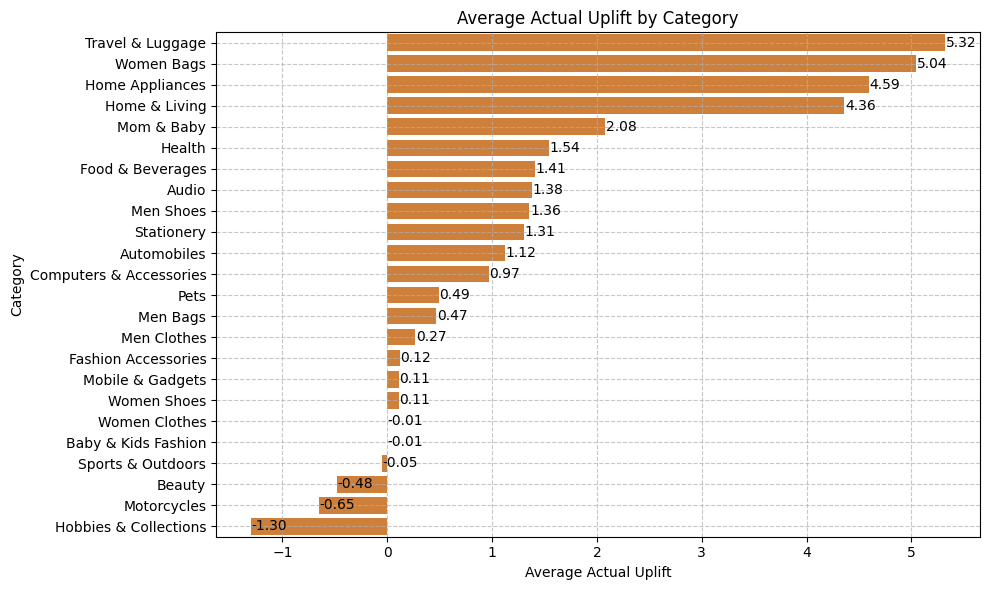

In [58]:
temp = fs.groupby('level1_global_be_category')['uplift_base_avg'].mean().reset_index(name='uplift_base_avg')

temp = temp.sort_values(by='uplift_base_avg', ascending=False)

custom_palette = {
        'Top Uplift': '#e67e22',     # orange
        'Bottom Uplift': '#1f77b4'   # blue
    }

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=temp,
    x='uplift_base_avg',
    y='level1_global_be_category',
    dodge=False,
    color='#e67e22'
)

for patch in ax.patches:
    width = patch.get_width()
    y = patch.get_y() + patch.get_height() / 2
    ax.text(
        width + 0.005, 
        y,
        f'{width:.2f}',  
        va='center',
        ha='left',
        fontsize=10
    )

plt.xlabel('Average Actual Uplift')
plt.ylabel('Category')
plt.title('Average Actual Uplift by Category')
plt.grid(
    True, 
    #axis='x',
    linestyle='--', 
    alpha=0.7
    )
plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

uplift_scores = ['uplift_score','uplift_base_l7d','uplift_base_l14d','uplift_base_l30d']

for ax, us in zip(axes,uplift_scores):
    sns.barplot(data=fs,x='cluster',y=us, ax=ax, color='skyblue')
    ax.axhline(0, ls='--', color='red')
    ax.set_title(f'Uplift by Cluster: {us}')
    if us == 'uplift_score':
        sns.barplot(data=fs,x='cluster',y=us, ax=ax, color='darkorange')

plt.suptitle('Predicted & Actual Uplift Comparison by Cluster', fontsize=16)
plt.show()

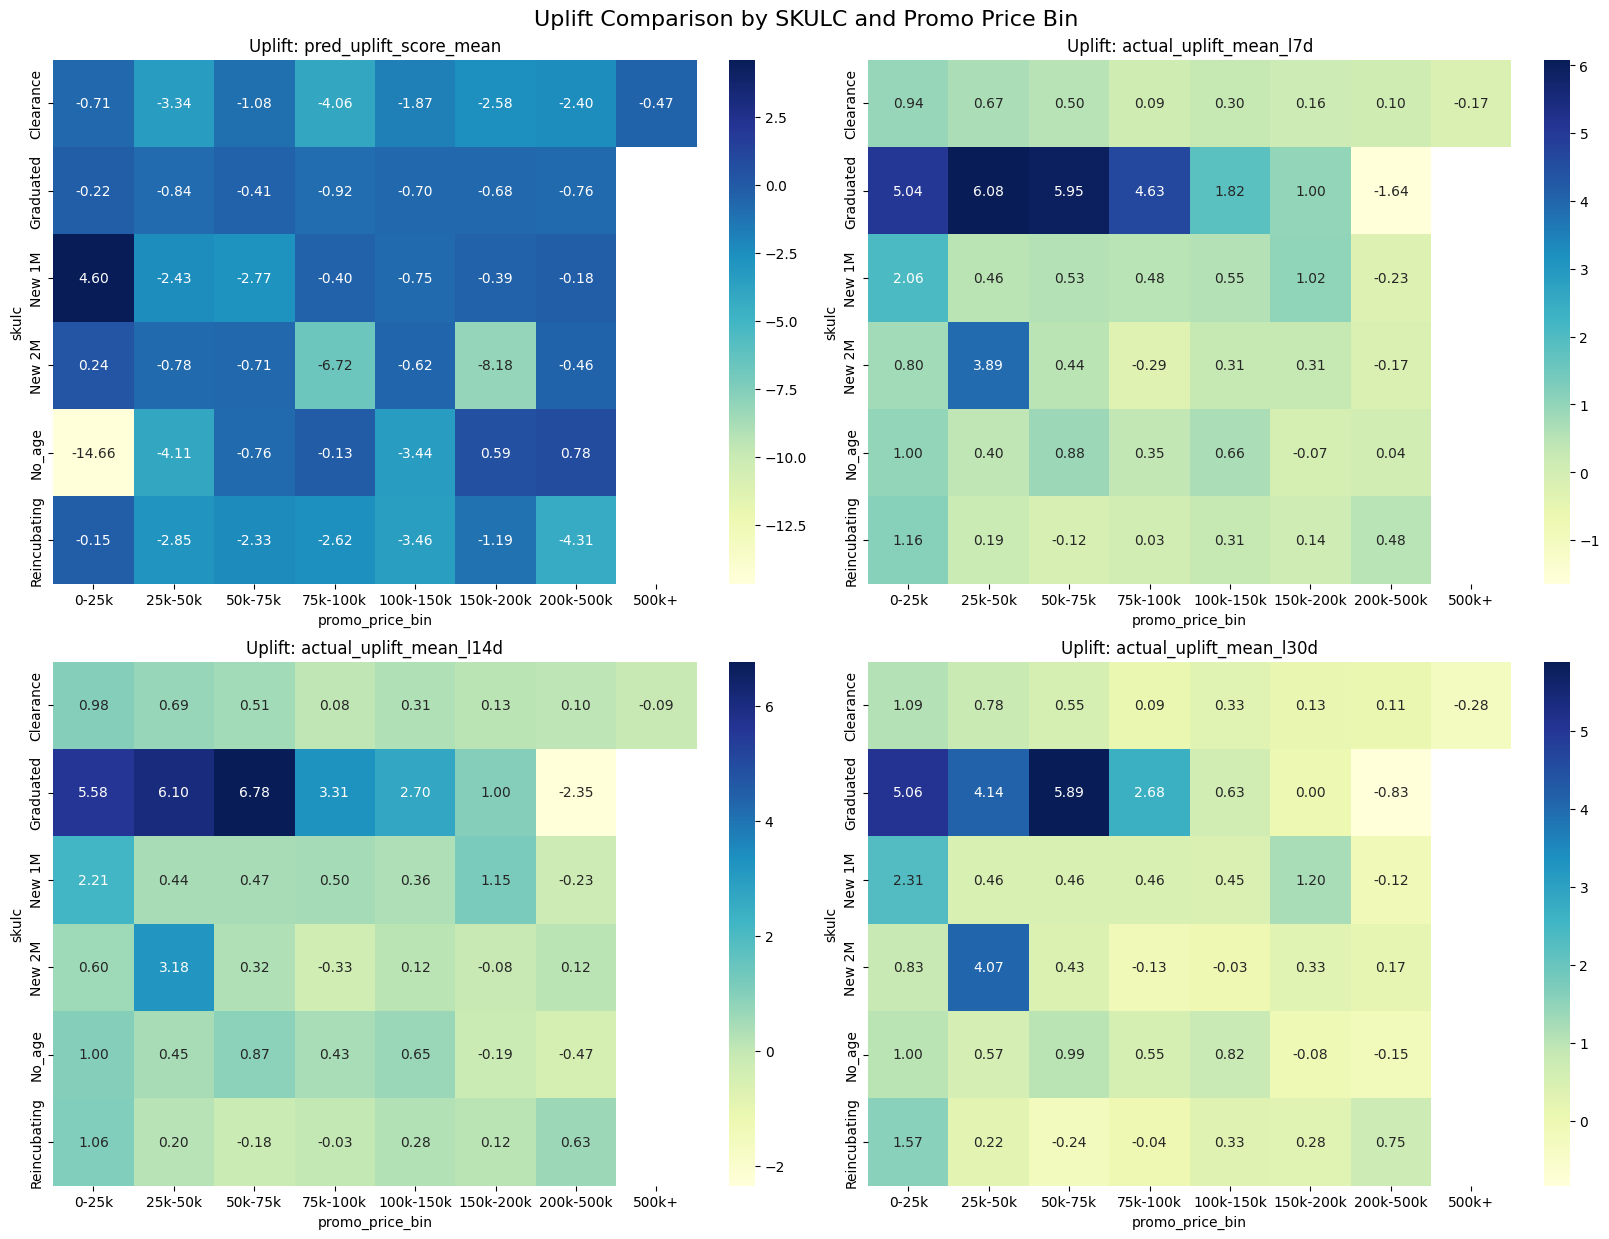

In [12]:
# Heatmaps

uplift_scores = ['pred_uplift_score_mean','actual_uplift_mean_l7d','actual_uplift_mean_l14d','actual_uplift_mean_l30d']

pivot_l7d = fs_grouped.pivot(index='skulc', columns='promo_price_bin', values='actual_uplift_mean_l7d')
pivot_l14d = fs_grouped.pivot(index='skulc', columns='promo_price_bin', values='actual_uplift_mean_l14d')
pivot_l30d = fs_grouped.pivot(index='skulc', columns='promo_price_bin', values='actual_uplift_mean_l30d')
pivot_score = fs_grouped.pivot(index='skulc', columns='promo_price_bin', values='pred_uplift_score_mean')

fig, axes = plt.subplots(2, 2, figsize=(16, 12), constrained_layout=True)

axes=axes.flatten()

for ax, us in zip(axes, uplift_scores):
    pivot = fs_grouped.pivot(index='skulc', columns='promo_price_bin', values=us)
    sns.heatmap(pivot, annot=True, fmt='.2f', cmap='YlGnBu', ax=ax)
    ax.set_title(f'Uplift: {us}')
    ax.set_ylabel('skulc')
    
plt.suptitle('Uplift Comparison by SKULC and Promo Price Bin', fontsize=16, y=1.02)
plt.show()

In [ ]:
# Spearman's correlation (actual vs predicted uplift grouped by skulc and price bin)

corr_rows = []

for (skulc, price_bin), group in fs.groupby(['skulc', 'promo_price_bin'], observed=True):
    row = {'skulc': skulc, 'promo_price_bin': price_bin}

    for window in ['uplift_base_l7d', 'uplift_base_l14d', 'uplift_base_l30d']:
        if group['uplift_score'].nunique() > 4 and group[window].nunique() > 4:
            corr, p = spearmanr(group[window],group['uplift_score'])
        else:
            corr, p = None, None

        row[f'corr_{window}'] = corr
        row[f'pval_{window}'] = p

    corr_rows.append(row)

# Convert to DataFrame
corr_table = pd.DataFrame(corr_rows)

# Heatmaps With p-value

# Create Pivot Tables 
bins_order = ['0-25k','25k-50k','50k-75k','75k-100k','100k-150k','150k-200k','200k-500k','500k+']

pivot_l7d = corr_table.pivot(index='skulc', columns='promo_price_bin', values='corr_uplift_base_l7d')[bins_order]
pivot_l14d = corr_table.pivot(index='skulc', columns='promo_price_bin', values='corr_uplift_base_l14d')[bins_order]
pivot_l30d = corr_table.pivot(index='skulc', columns='promo_price_bin', values='corr_uplift_base_l30d')[bins_order]

pval_l7d = corr_table.pivot(index='skulc', columns='promo_price_bin', values='pval_uplift_base_l7d')[bins_order]
pval_l14d = corr_table.pivot(index='skulc', columns='promo_price_bin', values='pval_uplift_base_l14d')[bins_order]
pval_l30d = corr_table.pivot(index='skulc', columns='promo_price_bin', values='pval_uplift_base_l30d')[bins_order]

# Format annotations: "corr pval"
def format_annot(corr_df, pval_df):
    annot = pd.DataFrame(index=corr_df.index, columns=corr_df.columns, dtype=str)

    for i in annot.index:
        for j in annot.columns:
            corr = corr_df.loc[i, j]
            p = pval_df.loc[i, j]
            if pd.isna(corr) or pd.isna(p):
                annot.loc[i, j] = ""
            else:
                annot.loc[i, j] = f"{corr:.2f}\np={p:.2g}"

    return annot

annot_l7d = format_annot(pivot_l7d, pval_l7d)
annot_l14d = format_annot(pivot_l14d, pval_l14d)
annot_l30d = format_annot(pivot_l30d, pval_l30d)

# Plot Heatmaps
fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

sns.heatmap(pivot_l7d.astype(float), annot=annot_l7d.values, fmt='', cmap='coolwarm', center=0, ax=axes[0])
axes[0].set_title('Spearman Corr: L7D')

sns.heatmap(pivot_l14d.astype(float), annot=annot_l14d.values, fmt='', cmap='coolwarm', center=0, ax=axes[1])
axes[1].set_title('Spearman Corr: L14D')

sns.heatmap(pivot_l30d.astype(float), annot=annot_l30d.values, fmt='', cmap='coolwarm', center=0, ax=axes[2])
axes[2].set_title('Spearman Corr: L30D')

for ax in axes:
    ax.set_xlabel('Promo Price Bin')
    ax.set_ylabel('SKULC')

plt.suptitle('Spearman Correlation & P-Values: Predicted vs Actual Uplift', fontsize=16, y=1.05)
plt.show()

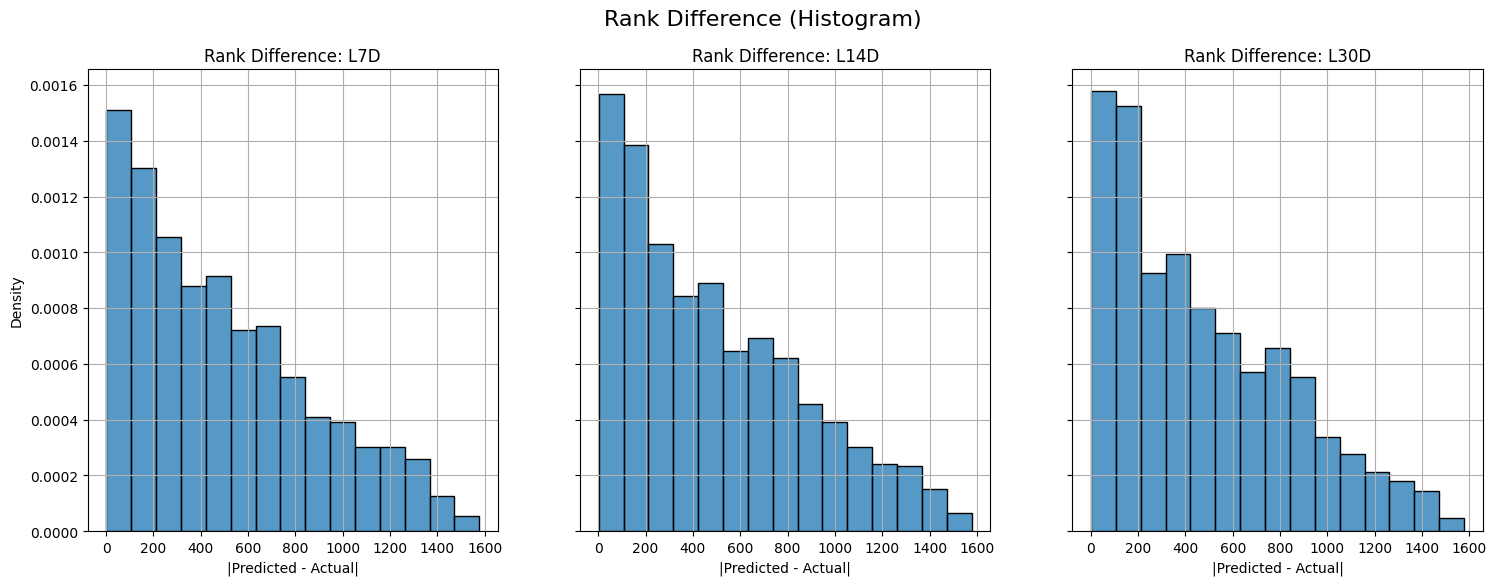

In [9]:
# Histogram for Rank Difference (No outliers removed)
fs[['predicted_rank','actual_rank_base_l7d', 'actual_rank_base_l14d','actual_rank_base_l30d']]

fs['rank_diff_l7d'] = abs(fs['predicted_rank'] - fs['actual_rank_base_l7d'])
fs['rank_diff_l14d'] = abs(fs['predicted_rank'] - fs['actual_rank_base_l14d'])
fs['rank_diff_l30d'] = abs(fs['predicted_rank'] - fs['actual_rank_base_l30d'])

diffs = {
    "L7D":fs['rank_diff_l7d'],
    "L14D":fs['rank_diff_l14d'],
    "L30D":fs['rank_diff_l30d']
}

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for ax, (label, diff) in zip(axes, diffs.items()):
    sns.histplot(diff, kde=False, bins=15, ax=ax, stat='density')
    ax.set_title(f"Rank Difference: {label}")
    ax.set_xlabel("|Predicted - Actual|")
    #ax.axvline(0, color='red', linestyle='--')
    ax.grid(True)

plt.suptitle('Rank Difference (Histogram)', fontsize=16)
plt.show()

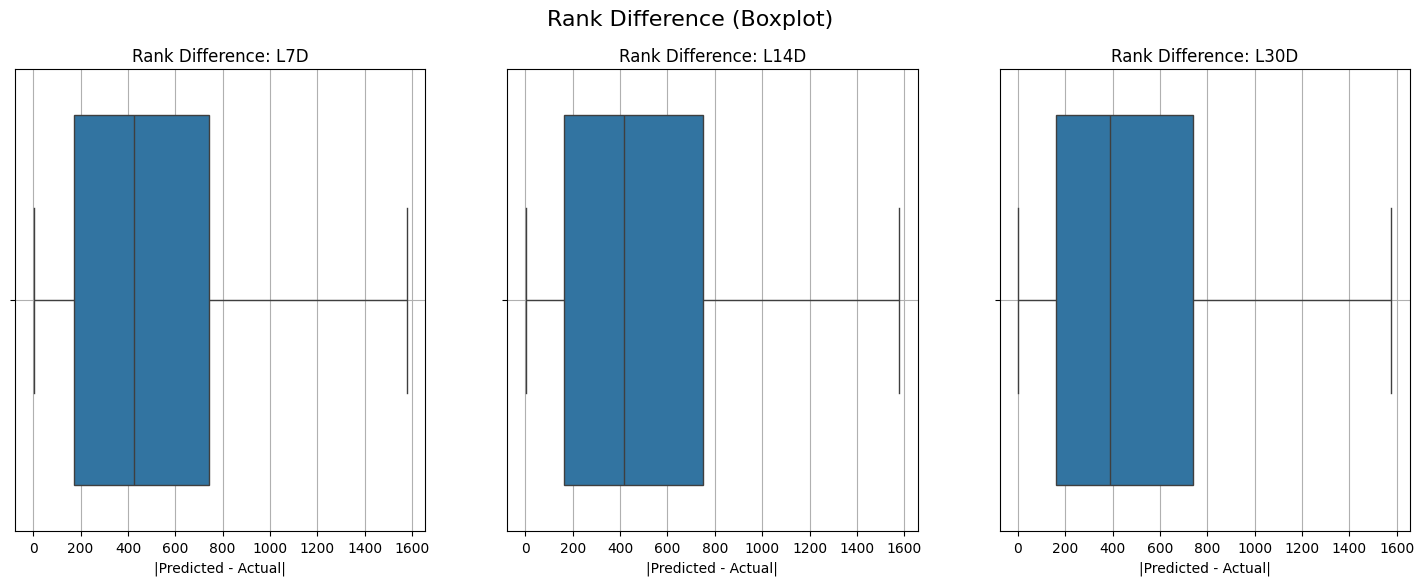

In [10]:
# Boxplots for Rank Difference

fig, axes = plt.subplots(1, 3, figsize=(18,6))

sns.boxplot(x=fs['rank_diff_l7d'], ax=axes[0])
axes[0].set_title('Rank Difference: L7D')

sns.boxplot(x=fs['rank_diff_l14d'], ax=axes[1])
axes[1].set_title('Rank Difference: L14D')

sns.boxplot(x=fs['rank_diff_l30d'], ax=axes[2])
axes[2].set_title('Rank Difference: L30D')

for ax in axes:
    ax.set_xlabel('|Predicted - Actual|')
    ax.grid(True)

plt.suptitle('Rank Difference (Boxplot)', fontsize=16)
plt.show()

In [ ]:
# Spearman (actual and predicted uplift grouped by skulc and cluster)

results = []

grouped = fs.groupby(['cluster', 'skulc'], observed=True)

for (category, skulc), group in grouped:
    row = {
        'cluster': category,
        'skulc': skulc
    }

    for window in ['uplift_base_l7d', 'uplift_base_l14d', 'uplift_base_l30d']:
        if group['uplift_score'].nunique() > 4 and group[window].nunique() > 4:
            corr, pval = spearmanr(group['uplift_score'], group[window])
        else:
            corr, pval = np.nan, np.nan
        row[f'corr_{window}'] = corr
        row[f'pval_{window}'] = pval

    results.append(row)

# Convert to DataFrame
spearman_table = pd.DataFrame(results)

def pivot_heat_data(corr_col, pval_col):
    corr = spearman_table.pivot(index='skulc', columns='cluster', values=corr_col)
    pval = spearman_table.pivot(index='skulc', columns='cluster', values=pval_col)

    # Format annotations with corr and p-value
    annot = corr.copy().astype(str)
    for i in corr.index:
        for j in corr.columns:
            c = corr.loc[i, j]
            p = pval.loc[i, j]
            if pd.notnull(c) and pd.notnull(p):
                annot.loc[i, j] = f"{c:.2f}\n(p={p:.2g})"
            else:
                annot.loc[i, j] = ""
    return corr, annot

pivot_l7d, annot_l7d = pivot_heat_data('corr_uplift_base_l7d', 'pval_uplift_base_l7d')
pivot_l14d, annot_l14d = pivot_heat_data('corr_uplift_base_l14d', 'pval_uplift_base_l14d')
pivot_l30d, annot_l30d = pivot_heat_data('corr_uplift_base_l30d', 'pval_uplift_base_l30d')

# Step 3: Plot heatmaps with annotations
fig, axes = plt.subplots(1, 3, figsize=(22, 10), sharey=True, constrained_layout=True)

sns.heatmap(pivot_l7d, annot=annot_l7d, fmt="", cmap='coolwarm', center=0, ax=axes[0])
axes[0].set_title("Spearman Corr: L7D")
axes[0].set_xlabel("Cluster")
axes[0].set_ylabel("SKULC")

sns.heatmap(pivot_l14d, annot=annot_l14d, fmt="", cmap='coolwarm', center=0, ax=axes[1])
axes[1].set_title("Spearman Corr: L14D")
axes[1].set_xlabel("Cluster")

sns.heatmap(pivot_l30d, annot=annot_l30d, fmt="", cmap='coolwarm', center=0, ax=axes[2])
axes[2].set_title("Spearman Corr: L30D")
axes[2].set_xlabel("Cluster")

plt.suptitle("Spearman Correlation & P-Values: Predicted vs Actual Uplift", fontsize=18)
plt.show()

TOP-10%

In [8]:
def top_k_accuracy(actual, predicted, k):
    actual_top_k = actual.nlargest(k).index
    predicted_top_k = predicted.nlargest(k).index
    return len(set(predicted_top_k).intersection(actual_top_k)) / k

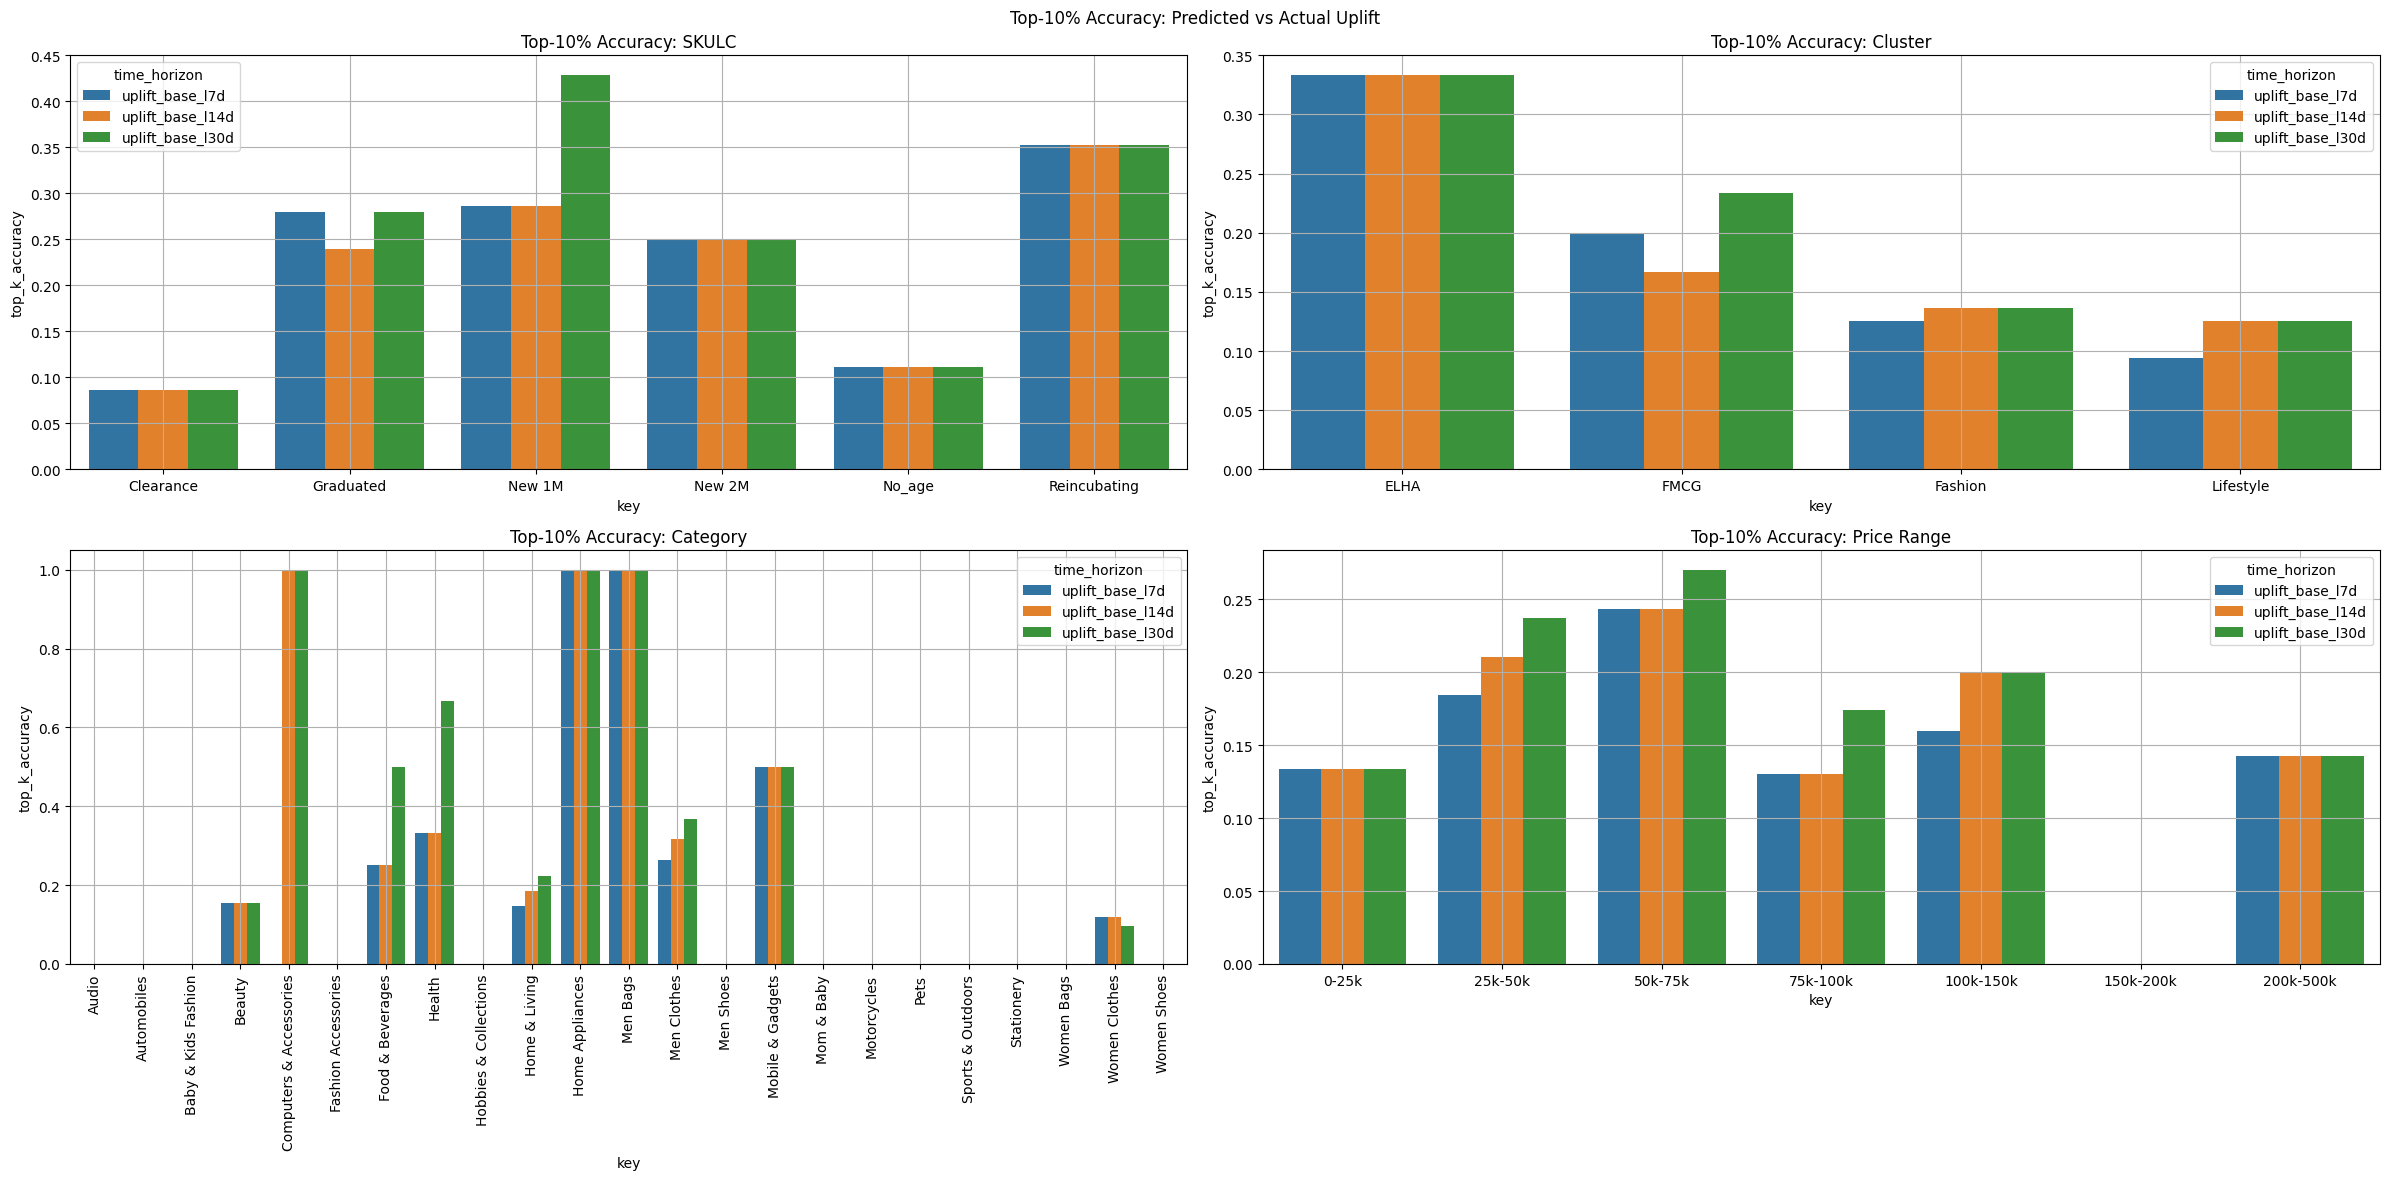

In [9]:
percentage = 0.1

results = {
    'skulc': [],
    'cluster': [],
    'level1_global_be_category': [],
    'promo_price_bin': []
}

time_horizons = ['uplift_base_l7d', 'uplift_base_l14d', 'uplift_base_l30d']

for dim in results.keys():
    for col in time_horizons:
        for key, group in fs.groupby(dim, observed=True):
            if len(group) >= 5:
                k = max(1,int(len(group)*percentage))
                score = top_k_accuracy(group[col], group['uplift_score'], k)
                results[dim].append({
                    'dimension': dim,
                    'key': key,
                    'time_horizon': col,
                    'top_k_accuracy': score
                })

# Convert to DataFrames
dfs = {dim: pd.DataFrame(res) for dim, res in results.items()}

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(24, 12))
titles = {
    'skulc': 'SKULC',
    'cluster': 'Cluster',
    'level1_global_be_category': 'Category',
    'promo_price_bin': 'Price Range'
}

# Flatten the 2D axes array to iterate over
axes = axes.flatten()

for ax, (dim, df) in zip(axes, dfs.items()):
    sns.barplot(data=df, x='key', y='top_k_accuracy', hue='time_horizon', ax=ax)
    ax.set_title(f'Top-10% Accuracy: {titles[dim]}')
    if dim in ['level1_global_be_category']:
        ax.tick_params(axis='x', rotation=90)
    ax.grid()

plt.suptitle('Top-10% Accuracy: Predicted vs Actual Uplift')
plt.tight_layout()
plt.show()

# Results as a dataframe
top10_df = pd.concat([
    pd.DataFrame(results['skulc']),
    pd.DataFrame(results['cluster']),
    pd.DataFrame(results['level1_global_be_category']),
    pd.DataFrame(results['promo_price_bin'])
    ], axis=0)

TOP-20%

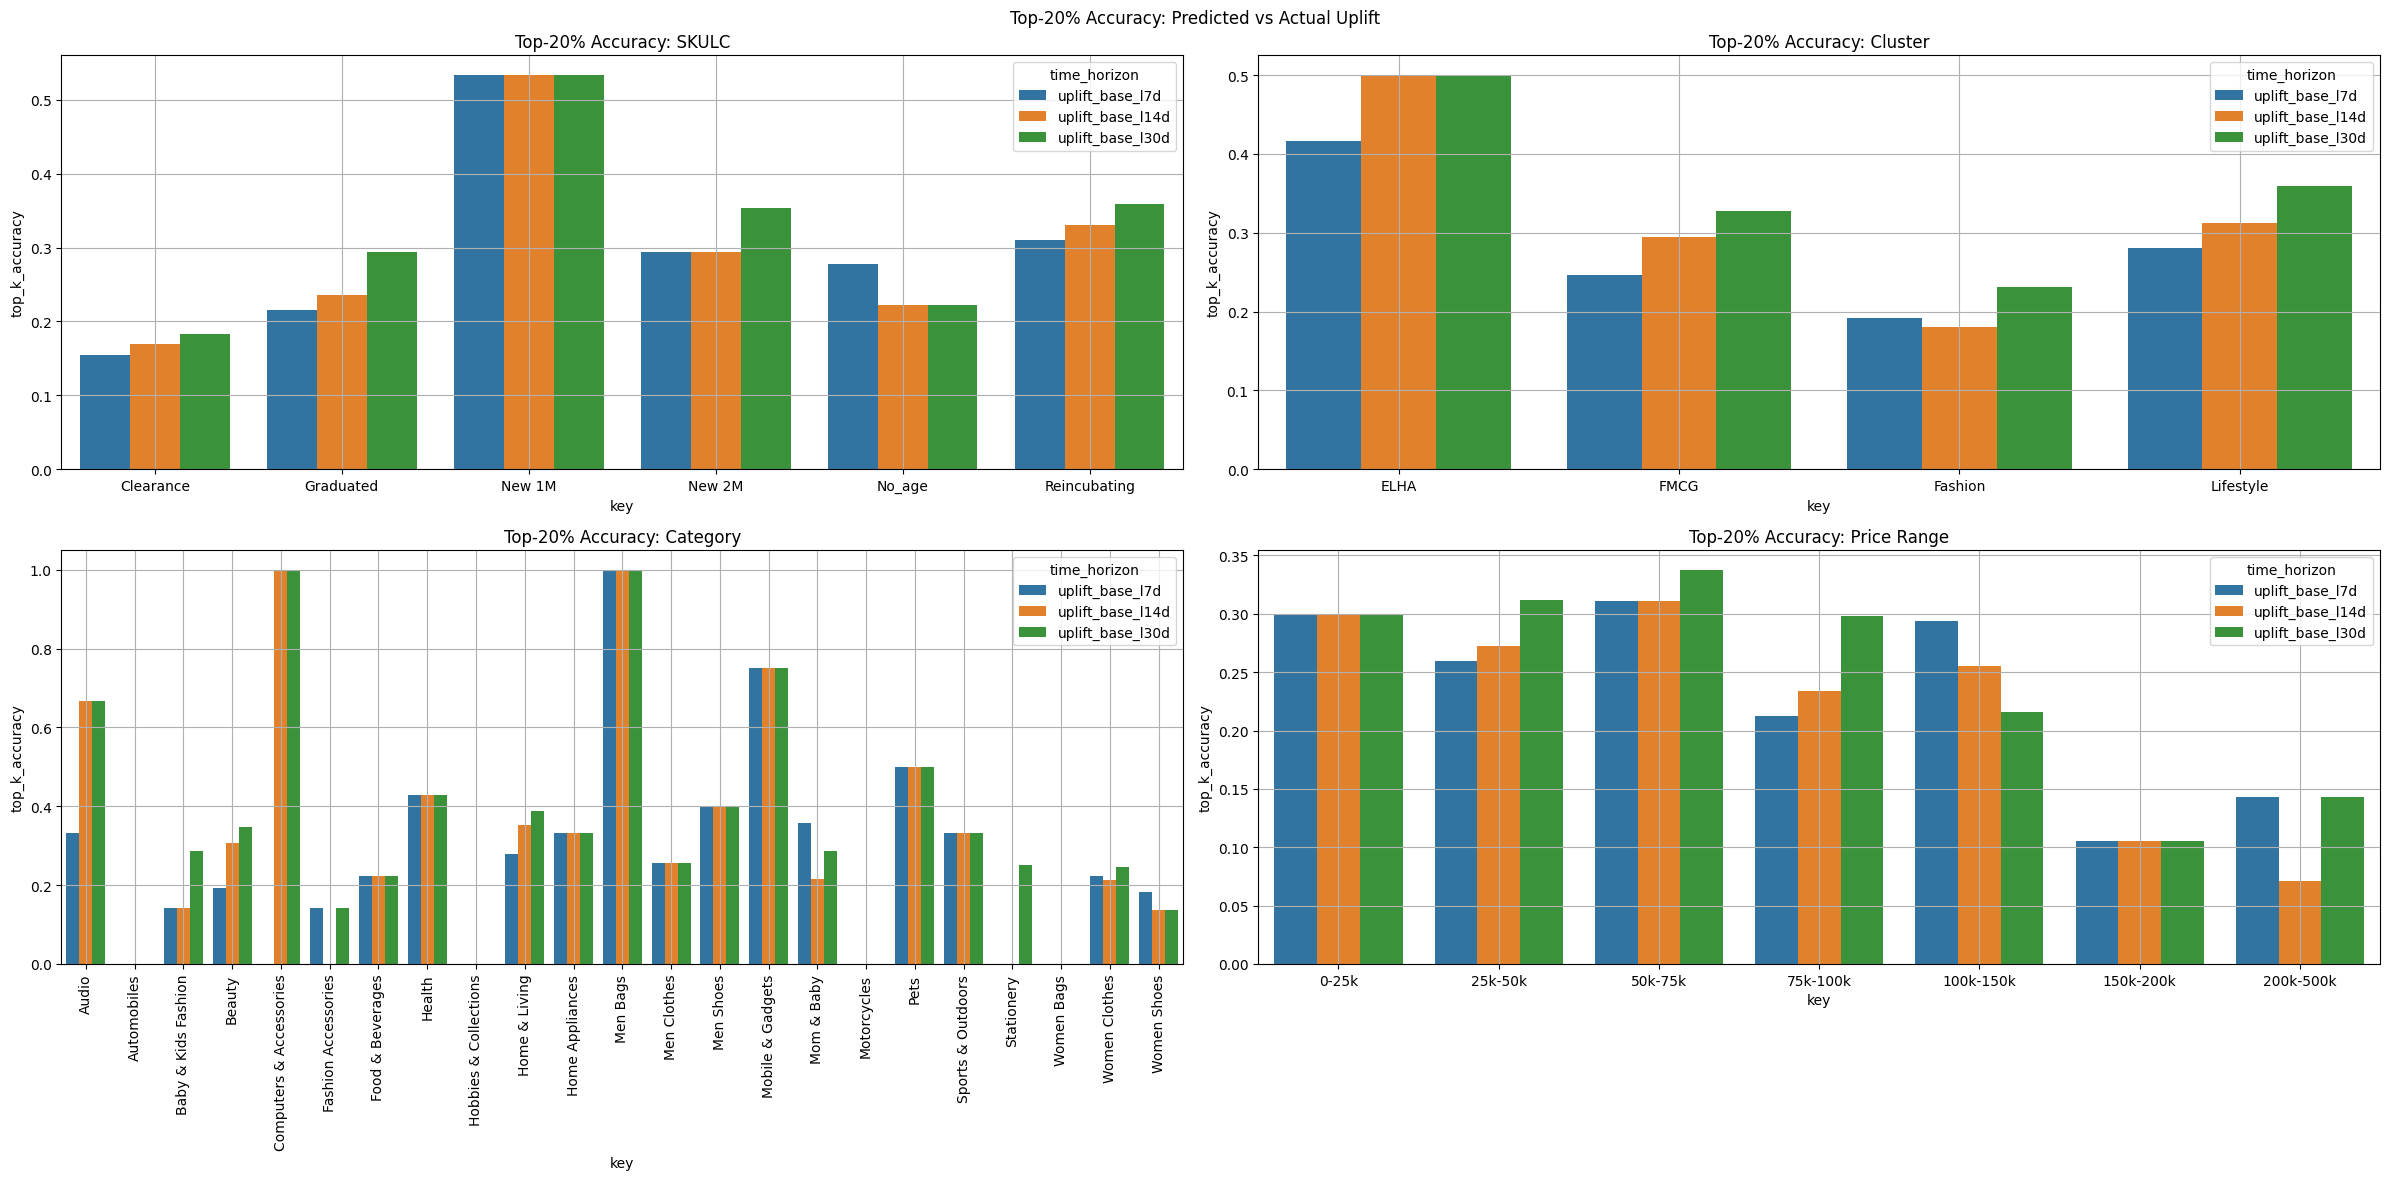

In [10]:
percentage = 0.2

results = {
    'skulc': [],
    'cluster': [],
    'level1_global_be_category': [],
    'promo_price_bin': []
}

time_horizons = ['uplift_base_l7d', 'uplift_base_l14d', 'uplift_base_l30d']

for dim in results.keys():
    for col in time_horizons:
        for key, group in fs.groupby(dim, observed=True):
            if len(group) >= 5:
                k = max(1,int(len(group)*percentage))
                score = top_k_accuracy(group[col], group['uplift_score'], k)
                results[dim].append({
                    'dimension': dim,
                    'key': key,
                    'time_horizon': col,
                    'top_k_accuracy': score
                })

# Convert to DataFrames
dfs = {dim: pd.DataFrame(res) for dim, res in results.items()}

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(24, 12))  
titles = {
    'skulc': 'SKULC',
    'cluster': 'Cluster',
    'level1_global_be_category': 'Category',
    'promo_price_bin': 'Price Range'
}

# Flatten the 2D axes array to iterate over
axes = axes.flatten()

for ax, (dim, df) in zip(axes, dfs.items()):
    sns.barplot(data=df, x='key', y='top_k_accuracy', hue='time_horizon', ax=ax)
    ax.set_title(f'Top-20% Accuracy: {titles[dim]}')
    if dim in ['level1_global_be_category']:
        ax.tick_params(axis='x', rotation=90)
    ax.grid()

plt.suptitle('Top-20% Accuracy: Predicted vs Actual Uplift')
plt.tight_layout()
plt.show()

# Results as a dataframe
top20_df = pd.concat([
    pd.DataFrame(results['skulc']),
    pd.DataFrame(results['cluster']),
    pd.DataFrame(results['level1_global_be_category']),
    pd.DataFrame(results['promo_price_bin'])
    ], axis=0)

TOP-30%

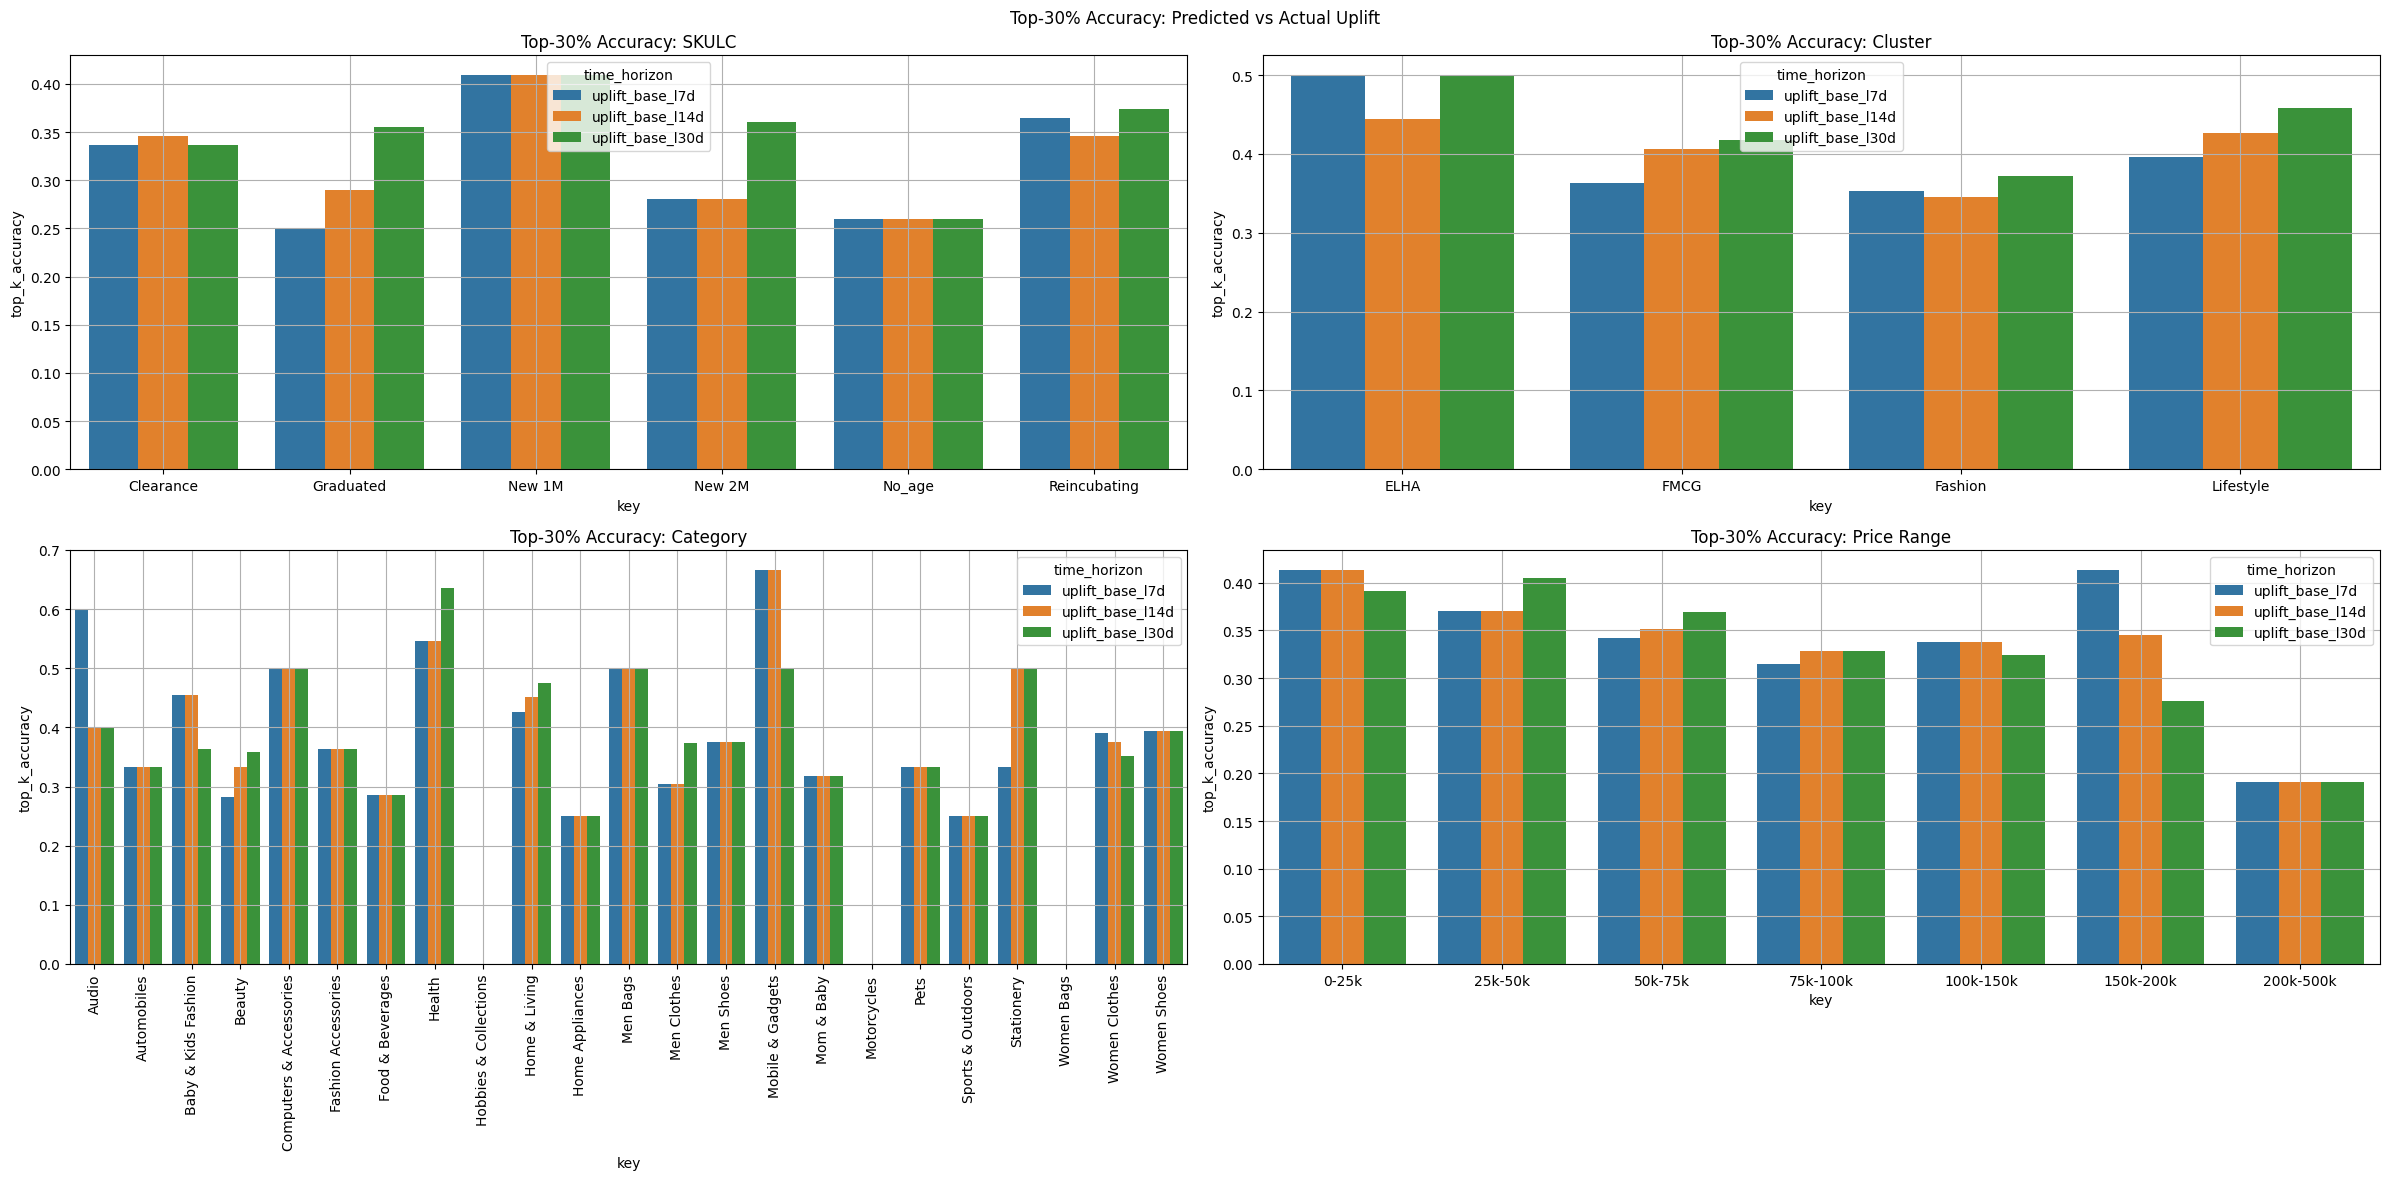

In [11]:
percentage = 0.3

results = {
    'skulc': [],
    'cluster': [],
    'level1_global_be_category': [],
    'promo_price_bin': []
}

time_horizons = ['uplift_base_l7d', 'uplift_base_l14d', 'uplift_base_l30d']

for dim in results.keys():
    for col in time_horizons:
        for key, group in fs.groupby(dim, observed=True):
            if len(group) >= 5:
                k = max(1,int(len(group)*percentage))
                score = top_k_accuracy(group[col], group['uplift_score'], k)
                results[dim].append({
                    'dimension': dim,
                    'key': key,
                    'time_horizon': col,
                    'top_k_accuracy': score
                })

# Convert to DataFrames
dfs = {dim: pd.DataFrame(res) for dim, res in results.items()}

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(24, 12))  
titles = {
    'skulc': 'SKULC',
    'cluster': 'Cluster',
    'level1_global_be_category': 'Category',
    'promo_price_bin': 'Price Range'
}

# Flatten the 2D axes array to iterate over
axes = axes.flatten()

for ax, (dim, df) in zip(axes, dfs.items()):
    sns.barplot(data=df, x='key', y='top_k_accuracy', hue='time_horizon', ax=ax)
    ax.set_title(f'Top-30% Accuracy: {titles[dim]}')
    if dim in ['level1_global_be_category']:
        ax.tick_params(axis='x', rotation=90)
    ax.grid()

plt.suptitle('Top-30% Accuracy: Predicted vs Actual Uplift')
plt.tight_layout()
plt.show()

# Results as a dataframe
top30_df = pd.concat([
    pd.DataFrame(results['skulc']),
    pd.DataFrame(results['cluster']),
    pd.DataFrame(results['level1_global_be_category']),
    pd.DataFrame(results['promo_price_bin'])
    ], axis=0)

TOP-50%

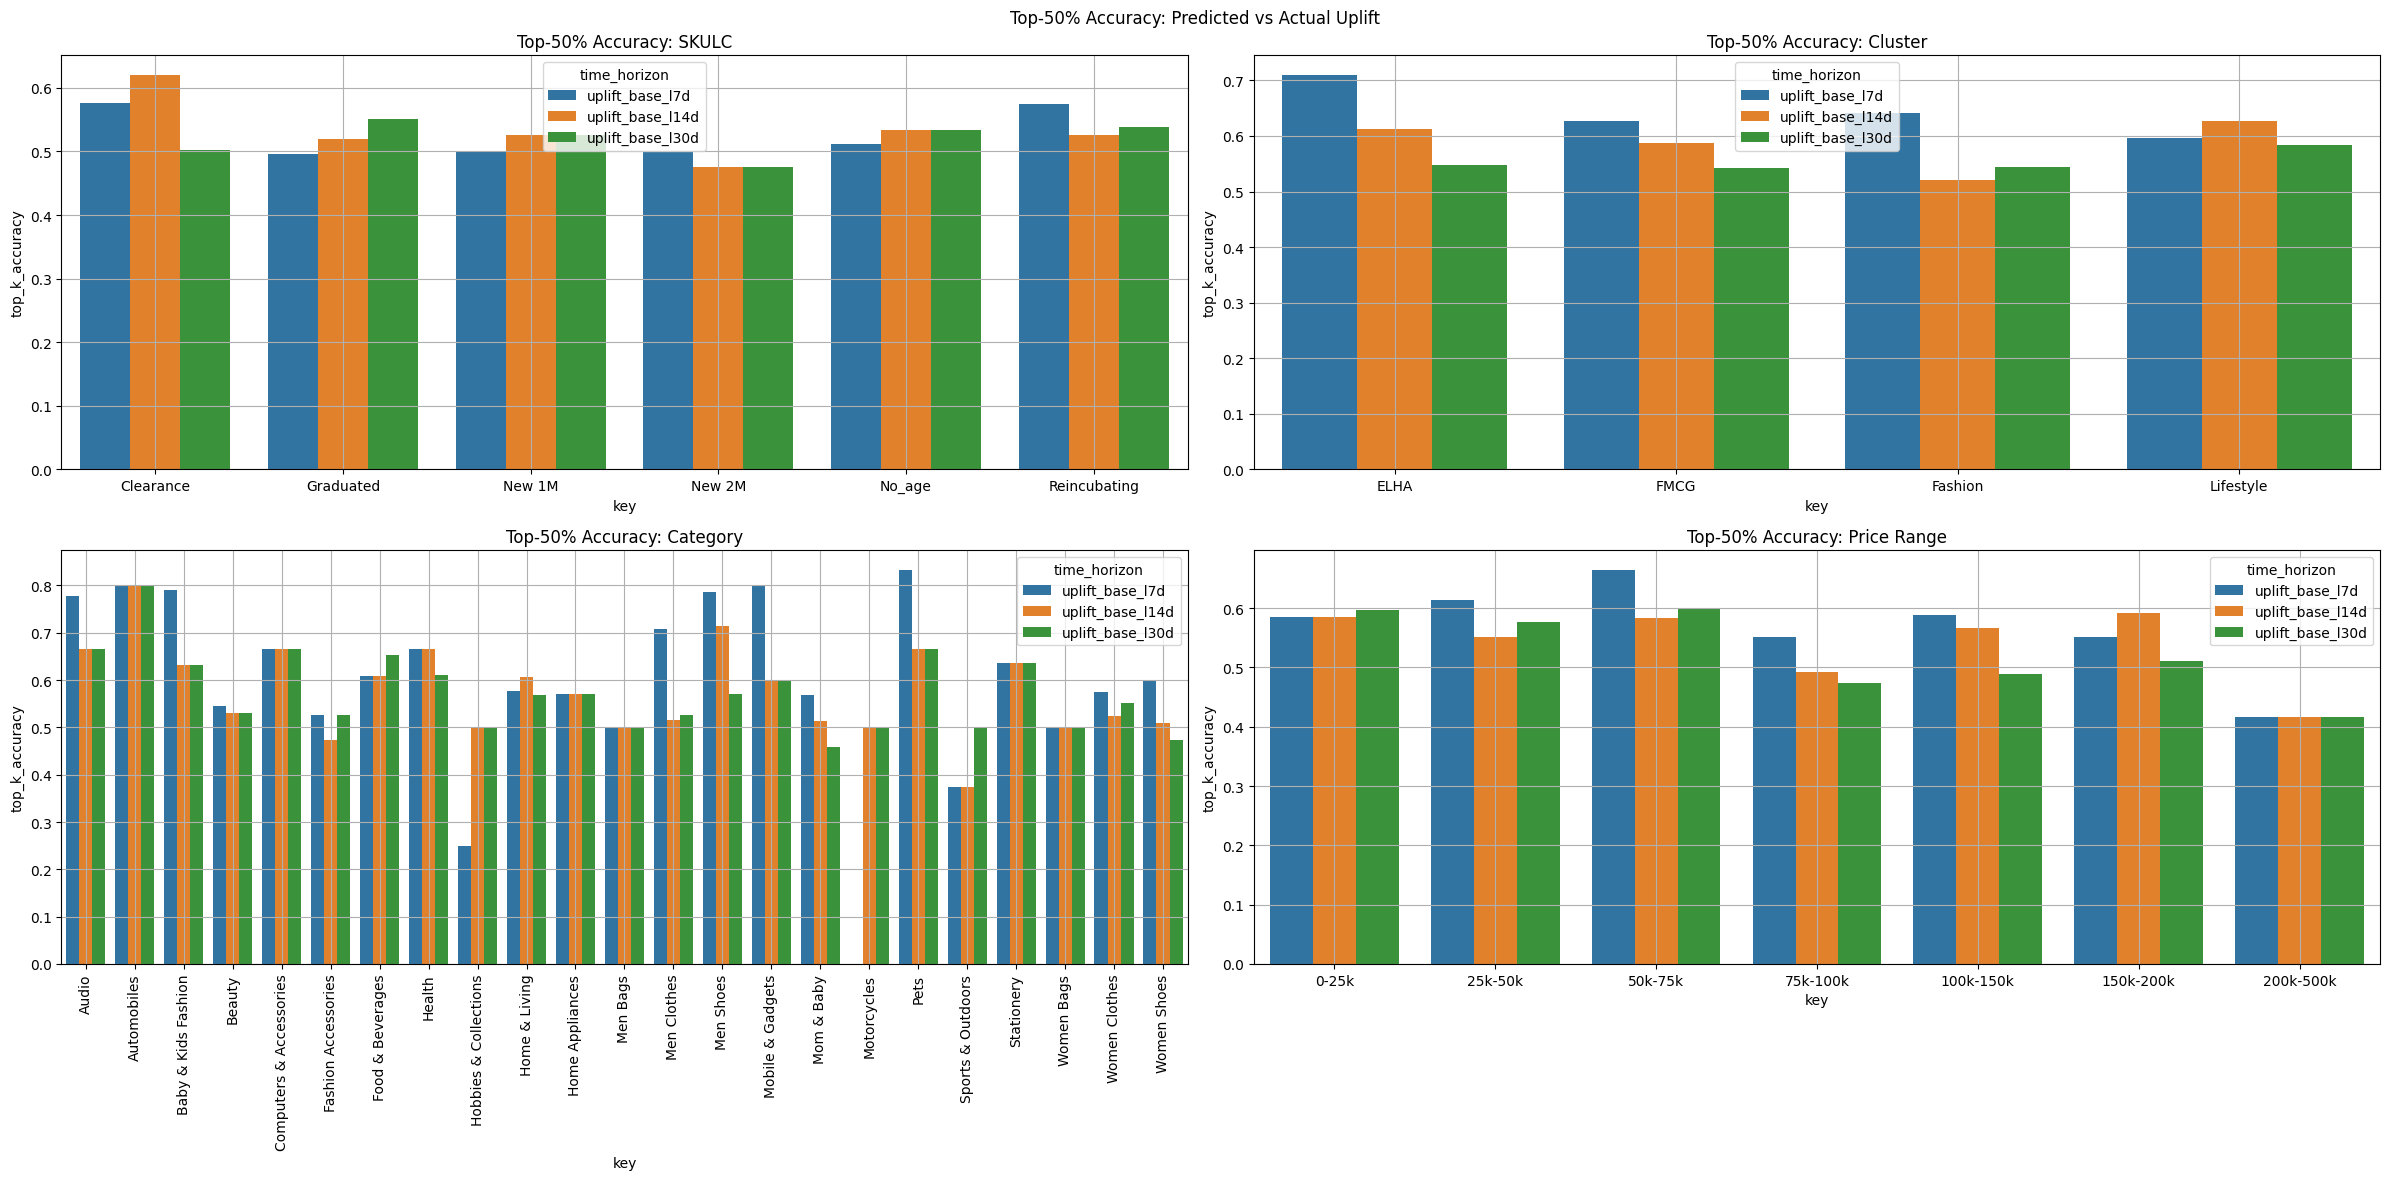

In [12]:
percentage = 0.5

results = {
    'skulc': [],
    'cluster': [],
    'level1_global_be_category': [],
    'promo_price_bin': []
}

time_horizons = ['uplift_base_l7d', 'uplift_base_l14d', 'uplift_base_l30d']

for dim in results.keys():
    for col in time_horizons:
        for key, group in fs.groupby(dim, observed=True):
            if len(group) >= 5:
                k = max(1,int(len(group)*percentage))
                score = top_k_accuracy(group[col], group['uplift_score'], k)
                results[dim].append({
                    'dimension': dim,
                    'key': key,
                    'time_horizon': col,
                    'top_k_accuracy': score
                })

# Convert to DataFrames
dfs = {dim: pd.DataFrame(res) for dim, res in results.items()}

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(24, 12))  
titles = {
    'skulc': 'SKULC',
    'cluster': 'Cluster',
    'level1_global_be_category': 'Category',
    'promo_price_bin': 'Price Range'
}

# Flatten the 2D axes array to iterate over
axes = axes.flatten()

for ax, (dim, df) in zip(axes, dfs.items()):
    sns.barplot(data=df, x='key', y='top_k_accuracy', hue='time_horizon', ax=ax)
    ax.set_title(f'Top-50% Accuracy: {titles[dim]}')
    if dim in ['level1_global_be_category']:
        ax.tick_params(axis='x', rotation=90)
    ax.grid()

plt.suptitle('Top-50% Accuracy: Predicted vs Actual Uplift')
plt.tight_layout()
plt.show()

# Results as a dataframe
top50_df = pd.concat([
    pd.DataFrame(results['skulc']),
    pd.DataFrame(results['cluster']),
    pd.DataFrame(results['level1_global_be_category']),
    pd.DataFrame(results['promo_price_bin'])
    ], axis=0)

SPEARMAN'S CORRELATION

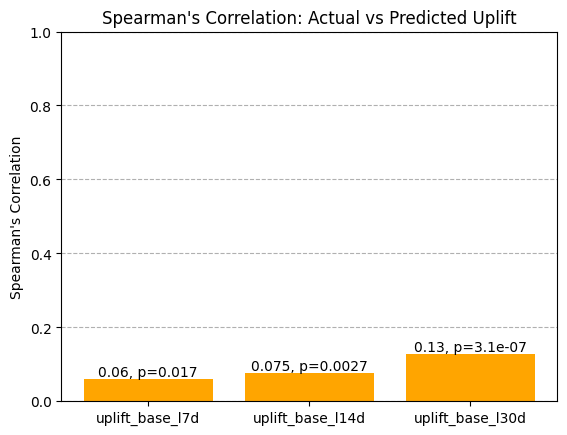

In [30]:
time_horizons = ['uplift_base_l7d', 'uplift_base_l14d', 'uplift_base_l30d']
corrs = []
pvals = []

for col in time_horizons:
    corr,p = spearmanr(fs['uplift_score'], fs[col])
    corrs.append(corr)
    pvals.append(p)

plt.bar(time_horizons,corrs,color='orange')
plt.grid(axis='y', linestyle='--')
plt.ylim(0,1)
plt.ylabel('Spearman\'s Correlation')
plt.title('Spearman\'s Correlation: Actual vs Predicted Uplift')
for i,(corr,p) in enumerate(zip(corrs,pvals)):
    plt.text(i, corr, f"{corr:.2g}, p={p:.2g}", ha='center', va='bottom')

In [ ]:
results = []

time_horizons = ['uplift_base_l7d', 'uplift_base_l14d', 'uplift_base_l30d']
dimensions = ['skulc', 'cluster', 'level1_global_be_category', 'promo_price_bin']

for dim in dimensions:
    for col in time_horizons:
        for key, group in fs.groupby(dim, observed=True):
            if len(group) >= 5:
                # Calculate Spearman correlation and p-value
                corr, pval = spearmanr(group['uplift_score'], group[col])
                results.append({
                    'dimension': dim,
                    'key': key,
                    'time_horizon': col,
                    'spearman_corr': corr,
                    'p_value': pval
                })

spearman_df = pd.DataFrame(results)

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(24, 12))  
axes = axes.flatten()  

titles = {
    'skulc': 'SKULC',
    'cluster': 'Cluster',
    'level1_global_be_category': 'Category',
    'promo_price_bin': 'Price Range'
}

for i, dim in enumerate(dimensions):
    subset = spearman_df[spearman_df['dimension'] == dim]
    sns.barplot(
        data=subset,
        x='key',
        y='spearman_corr',
        hue='time_horizon',
        ax=axes[i]
    )
    axes[i].set_title(f'Spearman Correlation: {titles[dim]}')
    axes[i].grid()
    if dim in ['level1_global_be_category']:
        axes[i].tick_params(axis='x', rotation=90)

plt.suptitle('Spearman Correlation between Predicted and Actual Uplift')
plt.tight_layout()
plt.show()

In [ ]:
# Plotting p-values in a separate 2x2 layout
fig, axes = plt.subplots(2, 2, figsize=(24, 12))
axes = axes.flatten()

titles = {
    'skulc': 'SKULC',
    'cluster': 'Cluster',
    'level1_global_be_category': 'Category',
    'promo_price_bin': 'Price Range'
}

for i, dim in enumerate(dimensions):
    subset = spearman_df[spearman_df['dimension'] == dim]
    sns.barplot(
        data=subset,
        x='key',
        y='p_value',
        hue='time_horizon',
        ax=axes[i]
    )
    axes[i].set_title(f'P-Values: {titles[dim]}')
    axes[i].axhline(0.05, ls='--', color='red', label='p=0.05 threshold')  # Optional: significance line
    axes[i].set_ylim(0, 1)
    axes[i].grid()
    if dim in ['level1_global_be_category', 'promo_price_bin']:
        axes[i].tick_params(axis='x', rotation=90)
    axes[i].legend()

plt.suptitle('P-Values for Spearman Correlation (Predicted vs Actual Uplift)')
plt.tight_layout()
plt.show()

TOP-K LINECHARTS

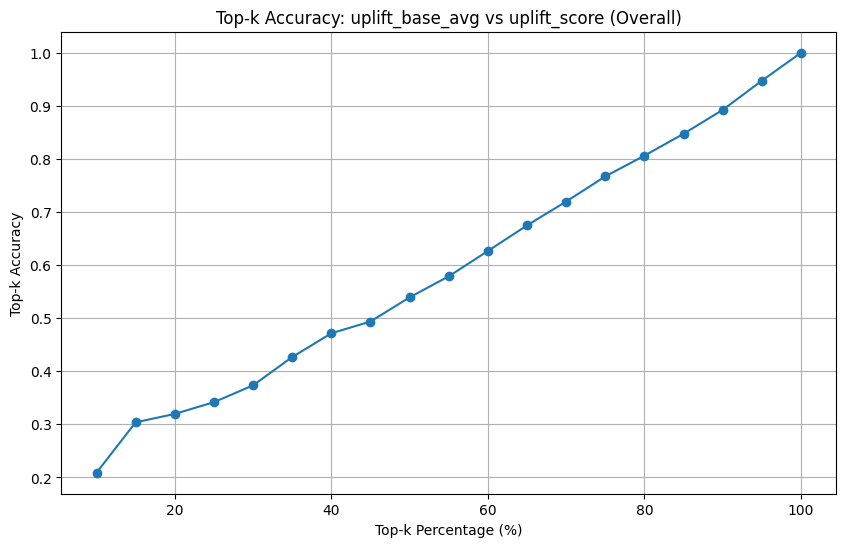

In [32]:
# Calculate top-k accuracy for a range of k values using uplift_base_avg and uplift_score
percentage_values = range(10, 101, 5)  # 10% to 100%
k_values = [max(1, int(len(fs) * pct / 100)) for pct in percentage_values]

topk_scores = [
    top_k_accuracy(fs['uplift_base_avg'], fs['uplift_score'], k)
    for k in k_values
]

# Plot the line graph
plt.figure(figsize=(10, 6))
plt.plot(percentage_values, topk_scores, marker='o')
plt.xlabel('Top-k Percentage (%)')
plt.ylabel('Top-k Accuracy')
plt.title('Top-k Accuracy: uplift_base_avg vs uplift_score (Overall)')
plt.grid(True)
plt.show()

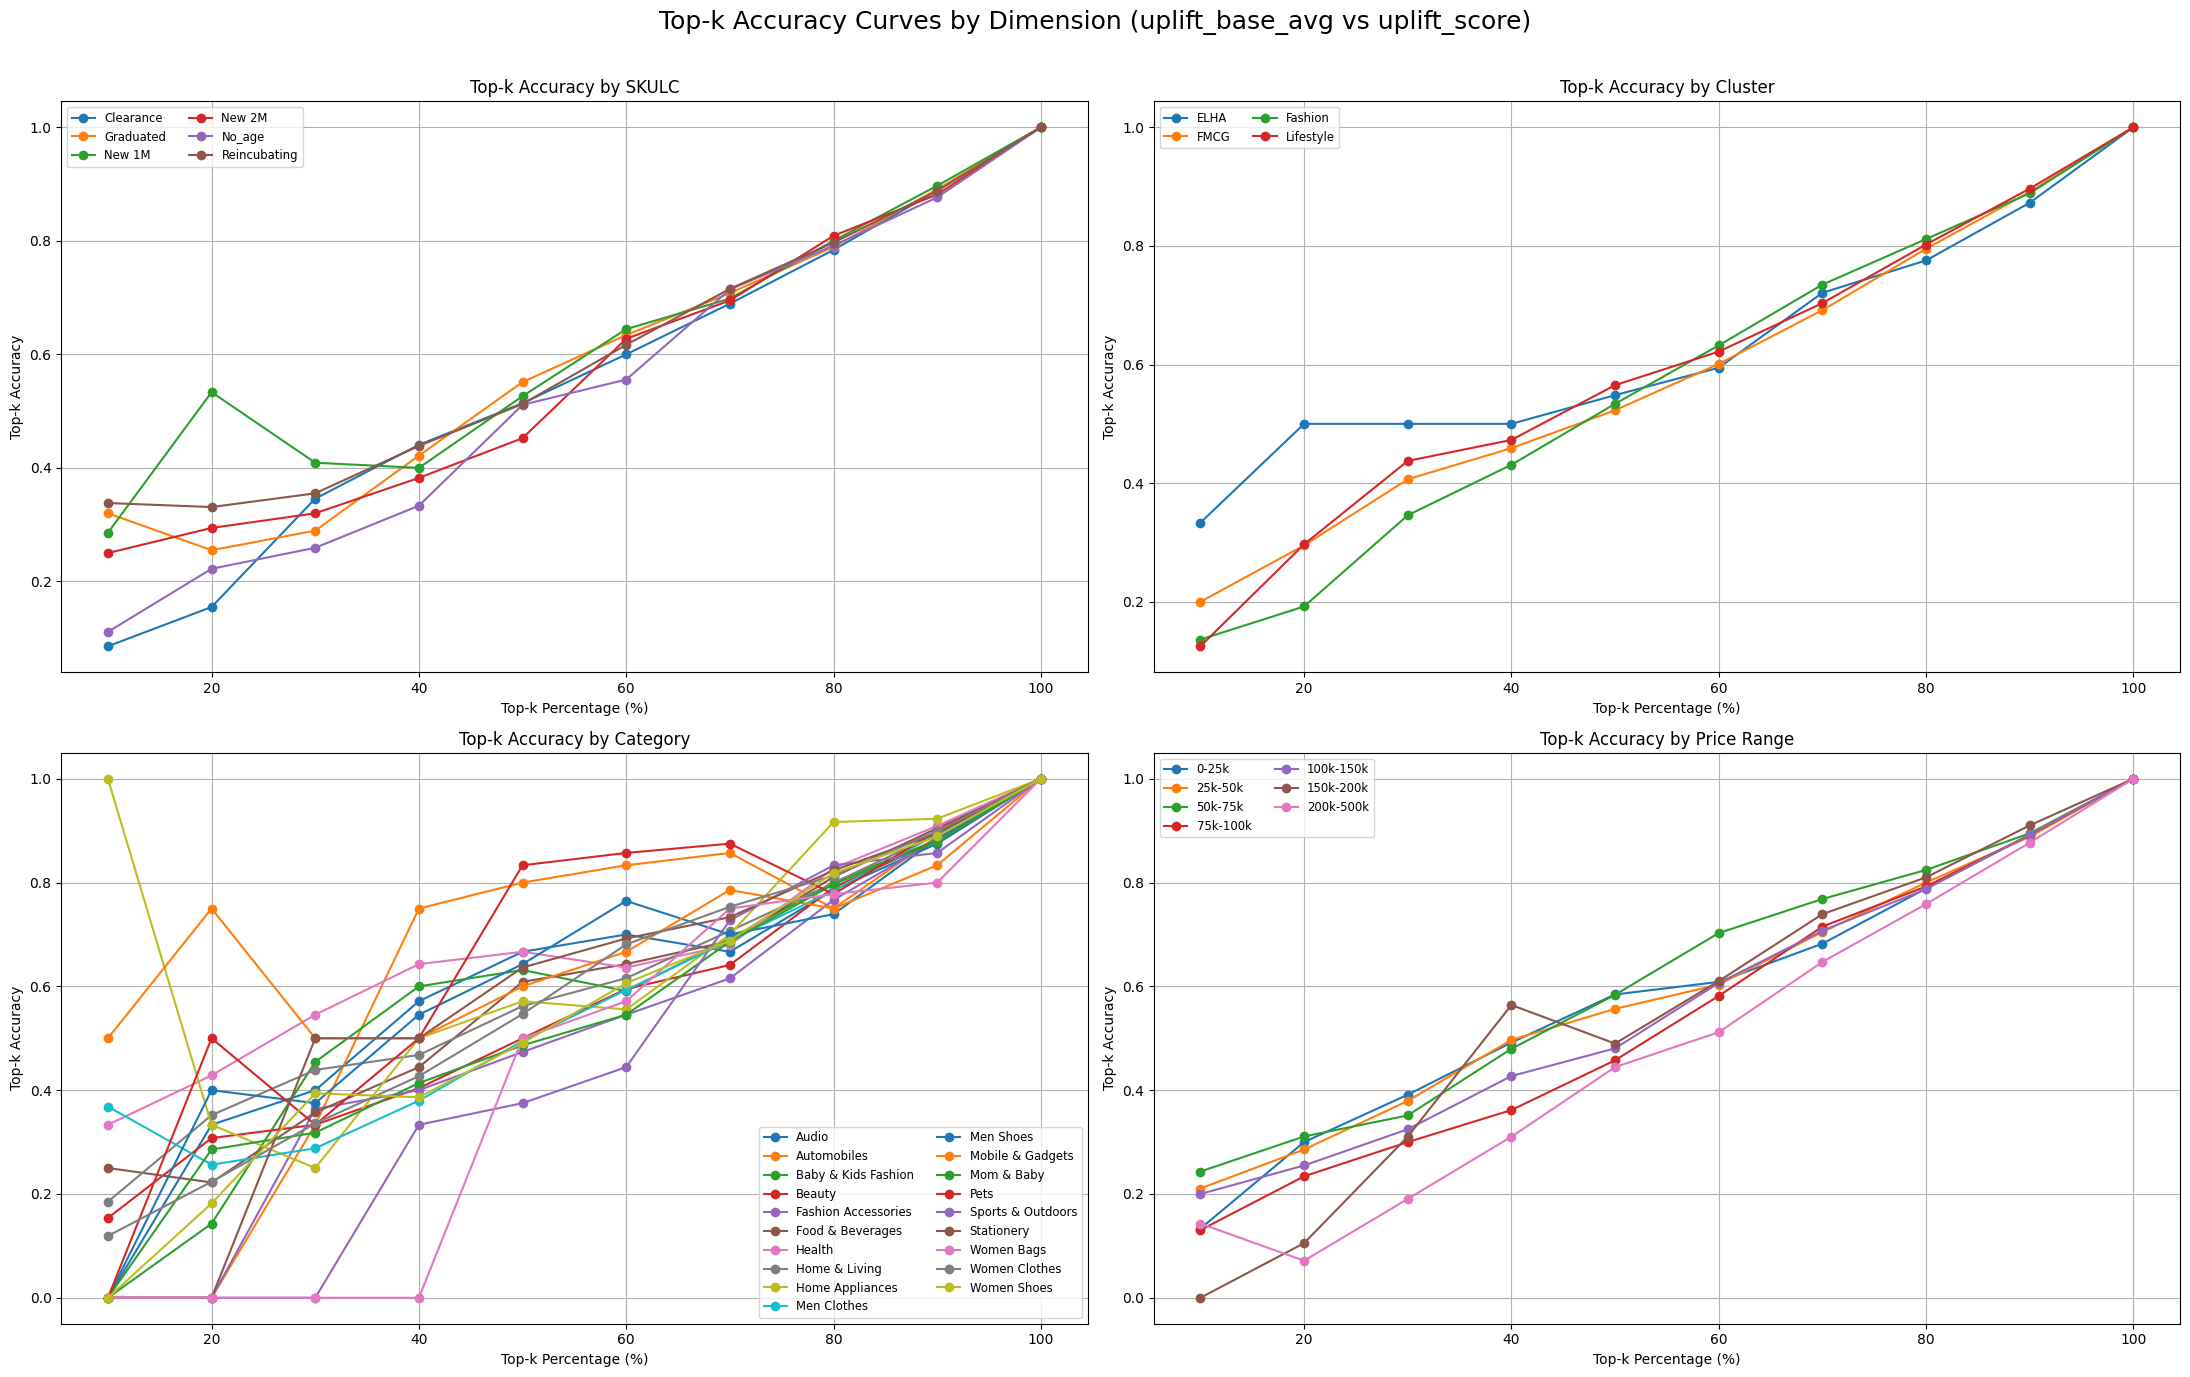

In [34]:
# Calculate top-k accuracy for a range of k percentages, separated by each dimension
dimensions = ['skulc', 'cluster', 'level1_global_be_category', 'promo_price_bin']
time_horizon = 'uplift_base_avg'

fig, axes = plt.subplots(2, 2, figsize=(22, 14))
axes = axes.flatten()

for ax, dim in zip(axes, dimensions):
    for key, group in fs.groupby(dim, observed=True):
        n = len(group)
        if n < 10:
            continue 

        percentage_values = range(10, 101, 10)  # From 10% to 100%
        k_values = [max(1, int(n * pct / 100)) for pct in percentage_values]

        scores = [
            top_k_accuracy(group[time_horizon], group['uplift_score'], k)
            for k in k_values
            if k <= n
        ]

        
        ax.plot(
            percentage_values[:len(scores)],
            scores,
            marker='o',
            label=str(key)
        )

    ax.set_title(f"Top-k Accuracy by {titles[dim]}")
    ax.set_xlabel('Top-k Percentage (%)')
    ax.set_ylabel('Top-k Accuracy')
    ax.legend(fontsize='small', loc='best', ncol=2)
    ax.grid(True)

plt.suptitle('Top-k Accuracy Curves by Dimension (uplift_base_avg vs uplift_score)', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()